<a href="https://colab.research.google.com/github/joyeetadey/HSI-classification-with-3D-CNN-using-DARTS/blob/main/Spectral_Preprocessing_with_LS_%26_TV_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install GDAL
!pip install spectral
!pip install scikit-learn
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 14.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#importing required pakages 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import scipy
from osgeo import gdal
import matplotlib.pyplot as plt 
from spectral import*
from math import log10, sqrt
import cv2
import math
import scipy.misc
import scipy.io as sio
try:
    from skimage.restoration import denoise_tv_chambolle
except ImportError:
    # skimage < 0.12
    from skimage.filters import denoise_tv_chambolle

# Importing the Dataset and its Analysis 

In [2]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"


!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"

--2023-01-10 14:57:44--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-01-10 14:57:44--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.17MB/s    in 2.6s    

2023-01-10 14:57:47 (2.17 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-01-10 14:57:47--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

In [4]:
## Importing Library
from scipy.io import loadmat

dataset = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
ground_truth = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [5]:
#The dimensions of the data.
print(f'Dataset: {dataset.shape}\nGround Truth: {ground_truth.shape}')
#print(f'Dataset1: {dataset1.shape}\nGround Truth1: {ground_truth1.shape}')

Dataset: (145, 145, 200)
Ground Truth: (145, 145)


In [7]:
x = dataset.shape[0]
y = ground_truth.shape[0]
dim = dataset.shape[2]
# spatial information
print("Value of x")
print(x)
print("--------------")
print("Value of y")
print(y)
print("--------------")


#spectral information
print("Band Size")
print(dim)

Value of x
145
--------------
Value of y
145
--------------
Band Size
200


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_band(dataset):
    plt.figure(figsize=(8, 6))
    # band_no = np.random.randint(dataset.shape[2])
    band_no = 13
    plt.imshow(dataset[:,:, band_no], cmap='gray')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()

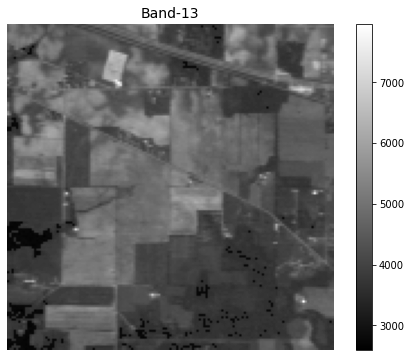

In [15]:
plot_band(dataset)

In [17]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [19]:
df = extract_pixels(dataset, ground_truth)
df.head()

100%|██████████| 200/200 [00:00<00:00, 345.02it/s]


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [43]:
df = df.drop(['class'],axis=1)
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,...,1021,1013,1012,1018,1015,1011,1001,1000,1009,1008
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,...,1023,1012,1014,1012,1024,998,1010,1006,1000,1000
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,...,1020,1016,1015,1016,1021,1008,1019,1003,1008,1000
21023,3155,4104,4106,4027,4139,4318,4413,4174,4140,3933,...,1015,1005,1011,1008,1012,1014,1007,1011,1005,1003


####Statistical Analysis

In [44]:
# mean of each band
df_mean = df.mean(axis=0)
mean = df_mean.values
mean

array([2957.36347206, 4091.32123662, 4277.50225922, 4169.95667063,
       4516.67866825, 4790.59514863, 4848.31757432, 4714.73250892,
       4668.90482759, 4439.06554102, 4407.19258026, 4307.54183115,
       4148.39667063, 4400.47462545, 4470.95881094, 4447.71110583,
       4286.07005945, 4070.359239  , 3967.32489893, 3861.22749108,
       3833.67486326, 3810.35077289, 3742.2101308 , 3657.67624257,
       3651.5368371 , 3562.26406659, 3453.27434007, 3489.04813317,
       3465.97003567, 3250.78606421, 3504.63890606, 3224.43005945,
       3511.5364566 , 3948.56223543, 4173.64646849, 4445.02420927,
       5309.74259215, 5950.96142687, 5937.520761  , 4137.62021403,
       6093.51248514, 6213.16161712, 5954.21612366, 5888.86615933,
       5472.7180975 , 5015.58259215, 5320.30378121, 5747.77740785,
       5670.19457788, 5679.59386445, 5610.72604043, 5643.01655172,
       5530.71586207, 4549.84998811, 4333.39395957, 4228.81545779,
       3666.59115339, 2324.13807372, 2476.99852556, 2703.66868

In [45]:
# standard deviation of each band
df_std = df.std(axis=0)
sd = df_std.values
sd

array([ 354.91870789,  230.39000547,  257.82763991,  280.7612538 ,
        346.03598364,  414.38213756,  469.24766715,  491.72834879,
        533.23285532,  539.90819524,  596.19188701,  674.2398587 ,
        758.73672696,  641.2215036 ,  634.47462268,  669.62796468,
        780.74092022,  852.02794574,  851.72698742,  862.12004748,
        876.97177566,  903.45373983,  913.73273506,  917.4586834 ,
        948.55073875,  964.29745485,  957.53039223, 1019.4629143 ,
       1033.90090639,  921.36706493,  888.80654274,  909.96290175,
        897.96402232,  853.07321059,  654.626044  ,  401.40267539,
        507.06136369,  720.97057545,  807.18178188,  644.5749196 ,
        884.46515381,  907.54333867,  854.1206309 ,  838.24454102,
        761.31113478,  685.0998554 ,  724.94823723,  789.18236576,
        776.83675079,  772.59193824,  757.29432541,  755.24220773,
        728.54185365,  606.09110664,  591.08509981,  580.21373683,
        608.14905899,  180.35480213,  195.54730265,  212.91166

<BarContainer object of 200 artists>

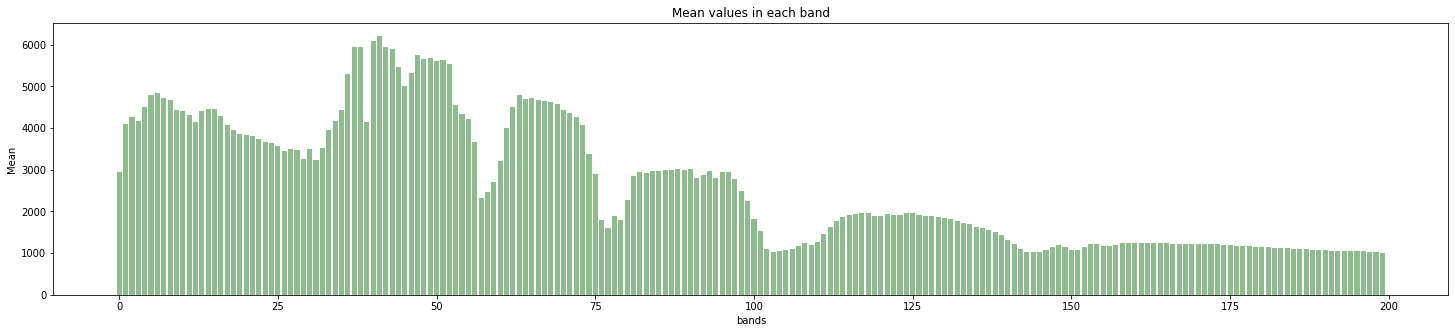

In [46]:
# plot of mean and bands 
from matplotlib import pyplot as plt
plt.figure(figsize=(25,5))
plt.title("Mean values in each band")
plt.xlabel("bands")
plt.ylabel("Mean")
plt.bar(range(len(mean)),mean,color='darkseagreen')

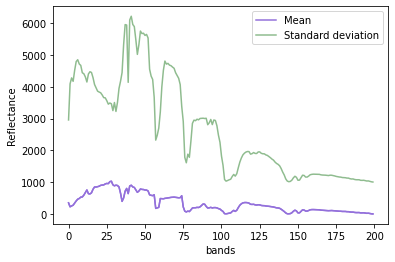

In [47]:
plt.plot(range(len(sd)),sd,color='mediumpurple')
plt.plot(range(len(mean)),mean,color='darkseagreen')
plt.plot(range(len(sd)),sd,color='mediumpurple')
plt.xlabel("bands")
plt.ylabel("Reflectance")
plt.legend(["Mean", "Standard deviation"])

# Required Functions

Inter Band Blockwise Correlation 
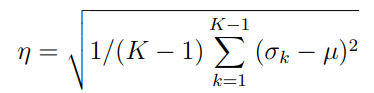

where k is the spectral band, K the total number of spectral
bands, σ the standard deviation of each band and μ the mean
of all standard deviation. The bands having standard deviation
larger than η will be considered as noisy.

In [48]:
#Inter Band Blockwise Correlation
def inter_band_corr(dim,sd): # no. of bands and standard deviation are the parameter.
  c=0
  sd_arr=np.array(sd) # array od sd 
  for i in range(0,dim) :
    s=sd[i]
    c=c+math.pow((s-np.mean(sd)),2) # computing inter bandwise correlation using mentioned formula 
  corr=np.sqrt(1/(dim-1)*c)
  return corr # returning the correlation 

The term peak signal-to-noise ratio (PSNR) is an expression for the ratio between the maximum possible value (power) of a signal and the power of distorting noise that affects the quality of its representation.  Because many signals have a very wide dynamic range, (ratio between the largest and smallest possible values of a changeable quantity) the PSNR is usually expressed in terms of the logarithmic decibel scale.

MSE = mean((f-g).^2)

PSNR = 10*log_10((max(f)))/((MSE)^0.5)

---------------------------------------------------------------




*   f represents the matrix data of original image
*   g represents the matrix data of noise
*   maxf is the maximum signal value that exists in our original

















In [49]:
#Peak Signal to noise Ratio
def PSNR(f, g):
    mse = np.mean((f - g) ** 2) # Mean Squared Error
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                   # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 10 * log10(max_pixel / sqrt(mse)) # psnr formula
    return psnr

In [50]:
#Second Derivation Matrix
def dif2_matrix(x):
    '''
    In case for len(x) = 5:
    dif = np.array(
    [[-2, 1, 0, 0, 0],
     [1, -2, 1, 0, 0],
     [0, 1, -2, 1, 0],
     [0, 0, 1, -2, 1],
     [0, 0, 0, 1, -2]])
    '''
    # Diagoenal elements are -2.
    dif_now = np.diag(np.ones(len(x))) * -2
     
    # Left elements of diagonal are 1.
    dif_pre_ones = np.ones(len(x)-1) # 1 vector.
    dif_pre = np.diag(dif_pre_ones, k=-1) # Diagonal matrix shiftedto left.
 
    # Right elements of diagonal are 1.
    dif_post_ones = np.ones(len(x)-1) # 1 vector.
    dif_post = np.diag(dif_post_ones, k=1) # Diagonal matrix shiftedto right.
     
    dif  =  dif_now + dif_pre + dif_post
    return dif

Spatial Least Square Method: The least square denoising
for one-dimensional signal
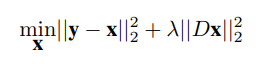


where ‘y’ is the one-dimensional input noisy signal, 

‘x’ is the actual resulting denoised signal 

 ‘D’ is the second derivative coefficient matrix
 
λ is the control parameter, which determines the weightage given to the terms

Solution to the minimization Problem is
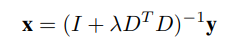


In [51]:
# 1D Least square denoising 
def LS_1D(dif,y,lamda):  # has three parameter - second derivation matrix , y- noise , control parameter 
  n=len(y) # length of noise
  I=np.eye(n) # identity matrix of the len of noise 
  x=np.linalg.inv(I+lamda*(dif)@dif.T)@y # solution equation 
  return x 

Implementing 2D least square algorithm for denoising with the help od 1D LS denoising.
The denoising is first performed column wise and then
row wise.

In [52]:
# 2D Least square denoising 
def LS_2D(dif,x,lamda):
  t=np.zeros(np.shape(x))
  t1=np.zeros(np.shape(x))
  for i in range(len(x)):
    temp=LS_1D(dif,x[i,:],lamda) # row wise denoising 
    t[i,:]=temp
  for i in range(len(t)):
    temp1=LS_1D(dif,t.T[i,:],lamda) # row wise denoising 
    t1[i,:]=temp1
  #output=LS_2D(dif,t.T,lamda) # column wise denoising 
  return t1
#y=(dataset_ar[28]) 
#t1=LS_2D(dif,y,0.1)
#output=LS_2D(dif,t.T,.1) # column wise denoising 

### Noisy Bands in the Given Hyperspectral Image

In [53]:
# calculating threshold 
corr=inter_band_corr(dim,sd)
print("Threshold --> ",corr)

Threshold -->  287.895650610585


In [54]:
dim

200

In [55]:
sd.shape

(200,)

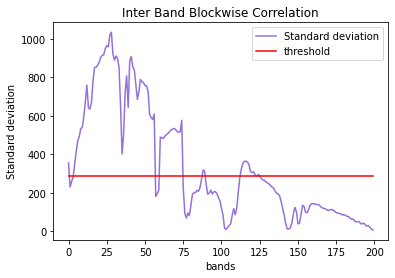

In [56]:
# plotting 
corr_arr=corr*np.ones(dim, dtype = int) # single value to array 
plt.plot(range(len(sd)),sd,color='mediumpurple') # ploting sd
plt.plot(range(len(sd)),corr_arr,'r')# threshold 
# x,y,title,legend 
plt.xlabel("bands")
plt.ylabel("Standard deviation")
plt.title("Inter Band Blockwise Correlation")
plt.legend([ "Standard deviation","threshold"])

In [57]:
 # values above the thresold is considered to be noise 
noise=[]
band_noise=[]
for i in range(0,len(sd)):
  # above threshold append the sd - threshold 
  if((sd[i]-corr)>0):
    noise.append(sd[i]-corr)
    band_noise.append(i)
  # below threshold append 0
  else:
     noise.append(0)

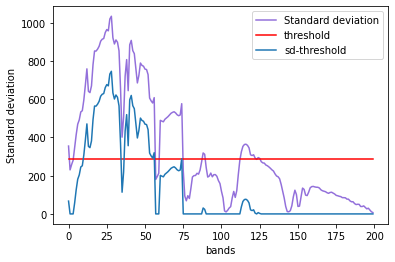

In [58]:
plt.plot(range(len(sd)),sd,color='mediumpurple')
plt.plot(range(len(sd)),corr_arr,'r')
plt.plot(range(len(noise)),noise)
plt.xlabel("bands")
plt.ylabel("Standard deviation")
plt.legend([ "Standard deviation","threshold","sd-threshold"])

In [59]:
print("bands with high noise :",band_noise)
print("Number of Noisy Band", len(band_noise))

bands with high noise : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 88, 89, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125]
Number of Noisy Band 83


In [60]:
temp=[]
for i in range(0,len(band_noise)):
  t=band_noise[i]
  temp.append(sd[t])
df = pd.DataFrame(list(zip(band_noise, temp)),
               columns =['Band Number', 'Standard Deviation'])
df.sort_values("Standard Deviation",ascending=False,ignore_index=True)
#df.iloc[41]

,Band Number,Standard Deviation
0,28,1033.900906
1,27,1019.462914
2,25,964.297455
3,26,957.530392
4,24,948.550739
...,...,...
78,119,309.032326
79,120,305.361601
80,124,294.684969
81,122,291.936215


# Implementing the Least Square Method for Denoising 

In [85]:
y1=(dataset[:,:, 3]) /255
dif_1=dif2_matrix(y1)
#x=np.zeros(np.shape(y))
x1=[]
psnr1=[]
for i in range(0,100):
  x1.append(LS_2D(dif_1,y1,i/100))
for i in range(len(x1)):
  psnr1.append(PSNR(y1, x1[i]))
#psnr


In [86]:
y2=(dataset[:,:, 44]) /255
dif_2=dif2_matrix(y2)
#x=np.zeros(np.shape(y))
x2=[]
psnr2=[]
for i in range(0,100):
  x2.append(LS_2D(dif_2,y2,i/100))
for i in range(len(x2)):
  psnr2.append(PSNR(y2, x2[i]))
#psnr


# Plots of Lambda vs PSNR after Denoising Using Least Square Method

<Figure size 576x576 with 0 Axes>

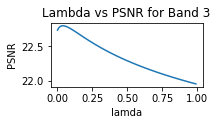

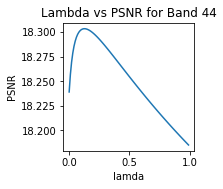

<Figure size 576x576 with 0 Axes>

In [65]:
l=[]
for i in range(0,100):
  l.append(i/100)
# plt.subplot(3,1,1),plt.plot(l,psnr)
# plt.xlabel("lamda")
# plt.ylabel("PSNR")
# plt.title('Lambda vs PSNR for Band 28')
# plt.figure(figsize=(8,8))
plt.subplot(3,2,1),plt.plot(l,psnr1);
plt.xlabel("lamda")
plt.ylabel("PSNR")
plt.title('Lambda vs PSNR for Band 3')
plt.figure(figsize=(8,8))
plt.subplot(3,3,1),plt.plot(l,psnr2)
plt.xlabel("lamda")
plt.ylabel("PSNR")
plt.title('Lambda vs PSNR for Band 44')
plt.figure(figsize=(8,8))

# Band Images (Original)

Text(0.5, 1.0, 'Band 44')

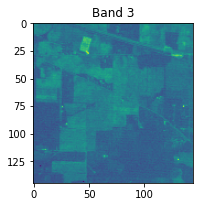

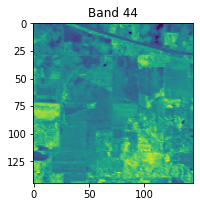

In [68]:
# plt.figure(figsize=(10,10))
# plt.subplot(3,1,1),plt.imshow(dataset_ar[28], cmap=plt.cm.gray);
# plt.title('Band 28');
plt.figure(figsize=(10,10))
plt.subplot(3,1,2),plt.imshow(dataset[:,:, 3], cmap=plt.cm.viridis);
plt.title('Band 3');
plt.figure(figsize=(10,10))
plt.subplot(3,1,3),plt.imshow(dataset[:,:, 44], cmap=plt.cm.viridis)
plt.title('Band 44')


# Band Images after Denoising Using Least Square Method

Text(0.5, 1.0, 'Band 44')

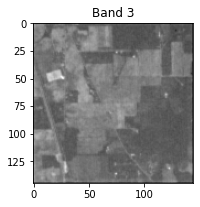

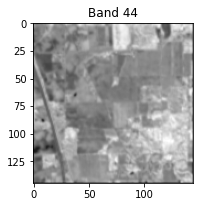

In [69]:
# plt.figure(figsize=(10,10))
# plt.subplot(3,1,1),plt.imshow(x[99], cmap=plt.cm.gray);
# plt.title('Band 28');
plt.figure(figsize=(10,10))
plt.subplot(3,1,2),plt.imshow(x1[10], cmap=plt.cm.gray);
plt.title('Band 3');
plt.figure(figsize=(10,10))
plt.subplot(3,1,3),plt.imshow(x2[20], cmap=plt.cm.gray)
plt.title('Band 44')


# Total Variation Denoising Method

This is one another kind of denoising method that can be represented by the given formulation:

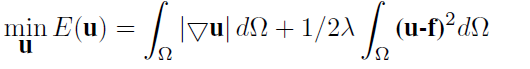
where 'f' is the noisy image, 'u' is the unknown denoised image, E is the minimization function of 'u' and 'λ' is the lagrange multiplier


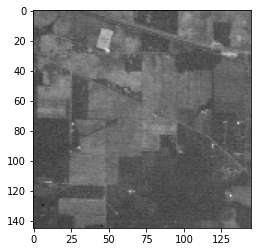

In [71]:
x=(dataset[:,:, 3])/255
Noise=x
Noise= Noise+ 0.05 * x.std()*np.random.randn(*x.shape)
denoised_x = denoise_tv_chambolle(Noise, weight=0.1) 
plt.imshow(Noise, cmap=plt.cm.gray)

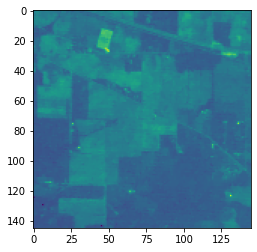

In [73]:
plt.imshow(denoised_x, cmap=plt.cm.viridis)

In [74]:
PSNR(denoised_x,Noise)

32.071875217975865

Comparison of Band 3's PSNR vs Weights

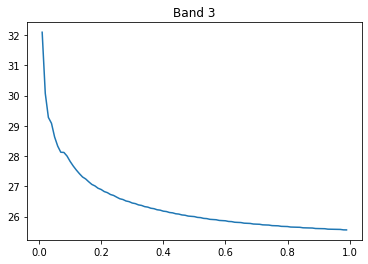

In [76]:
yy=(dataset[:,:, 3]) /255
xx=[]
psnr_=[]
for i in range(1,100):
  xx.append(denoise_tv_chambolle(yy, weight=i/10))
for i in range(len(xx)):
  psnr_.append(PSNR(yy, xx[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
plt.title('Band 3')
plt.plot(l1,psnr_)

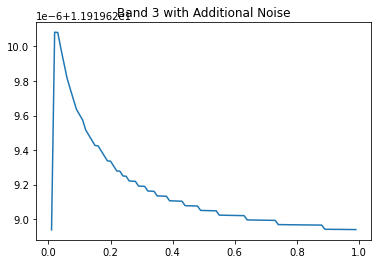

In [77]:
yy_n=(dataset[:,:, 3]) /255
Noise=0
Noise= Noise+ 0.05 * yy_n.std()*np.random.randn(*yy_n.shape)
xx_n=[]
psnr_n=[]
for i in range(1,100):
  xx_n.append(denoise_tv_chambolle(Noise, weight=i/10))
for i in range(len(xx_n)):
  psnr_n.append(PSNR(yy_n, xx_n[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
  plt.title('Band 3 with Additional Noise')
plt.plot(l1,psnr_n)

Comparison of Band 44's PSNR vs Weights

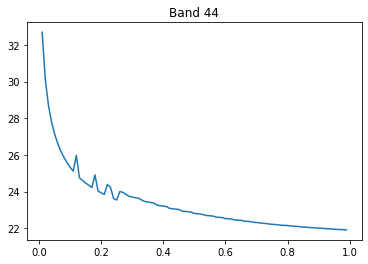

In [81]:
yy3=(dataset[:,:, 44]) /255
xx3=[]
psnr_44=[]
for i in range(1,100):
  xx3.append(denoise_tv_chambolle(yy3, weight=i/10))
for i in range(len(xx)):
  psnr_44.append(PSNR(yy3, xx3[i]))
#psnr
l1=[]
for i in range(1,100):
  l1.append(i/100)
plt.title('Band 44')
plt.plot(l1,psnr_44)

### Conclusion

From the above statitics we can conclude that the total variation denoising technique is found to be superior to the spatial least square method.

